

1.   스팸 분류-다양하게. lstm, gru, 갯수 제한 등등.
2.   스팸 분류-머신러닝으로. Tfidvectorizor + LR 등.



# 1.스팸 분류-다양하게. lstm, gru, 갯수 제한 등등.

##스팸 데이터 전처리

In [1]:
url = 'https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv'

In [2]:
import pandas as pd
df=pd.read_csv(url,encoding='latin1')
df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [3]:
#selection
df=df[['v1','v2']]

데이터 전처리

In [4]:
df.drop_duplicates(subset=['v2'],inplace=True)
df.v1 = df.v1.replace(['ham','spam'],[0,1])
df.head(3)


,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...


In [5]:
x=df.v2.values
y=df.v1.values

x.shape,y.shape

((5169,), (5169,))

In [6]:
#전처리 완료된 파일을 만들어 둔다.
df.to_csv('스팸_전처리완료.csv',index=False)

텍스트 전처리

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [8]:
#encoding, 구둣점 제거, 소문자로 변환
import re

def preprocessing(s):
    s=s.encode('utf8').decode('ascii','ignore')
    s=re.sub('[^a-z0-9 ]','',s.lower())
    return s


In [9]:
X_data=[preprocessing(sent) for sent in x]
X_data[2]

'free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive entry questionstd txt ratetcs apply 08452810075over18s'

In [10]:
t=Tokenizer()
t.fit_on_texts(X_data)

vocab_size=len(t.word_index)+1
vocab_size

9479

In [11]:
#시퀀스 생성
sequences=t.texts_to_sequences(X_data)
print(sequences[2])

[54, 508, 8, 22, 4, 959, 960, 2, 217, 2566, 1291, 664, 2567, 2568, 268, 2569, 71, 2566, 2, 2570, 2, 336, 508, 3839, 84, 3840, 424, 3841]


In [12]:
max_len=max(len(seq) for seq in sequences)
max_len

171

In [13]:
#전체 데이터를 max_len 길이에 맞도록 0 padding
data=pad_sequences(sequences, maxlen=max_len)

- train/test data set 분리

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(
    data,y,stratify=y,test_size=0.2,random_state=2022
)
X_train.shape,X_test.shape,y_train.shape, y_test.shape

((4135, 171), (1034, 171), (4135,), (1034,))

- 모델 정의/설정/학습

In [15]:
import tensorflow as tf
import numpy as np
seed=2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [16]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM,GRU, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## 1-1.LSTM 스팸 분류
[0.06329356878995895, 0.9845260977745056]


In [19]:
model2=Sequential([
                  Embedding(vocab_size,32,input_length=max_len),
                  LSTM(32),
                  Dense(1,activation='sigmoid')
])

model2.compile('adam','binary_crossentropy',['accuracy'])
model2_path='best-spam-lstm.h5'
mc=ModelCheckpoint(model2_path,verbose=1,save_best_only=True)
es=EarlyStopping(patience=10)

hist2=model2.fit(
    X_train,y_train,validation_split=0.2,
    epochs=100,batch_size=64,callbacks=[mc,es]
)
best_model=load_model(model2_path)
best_model.evaluate(X_test,y_test)

Epoch 1/100
49/52 [===========================>..] - ETA: 0s - loss: 0.4717 - accuracy: 0.8514
Epoch 1: val_loss improved from inf to 0.25104, saving model to best-spam-lstm.h5
52/52 [==============================] - 3s 22ms/step - loss: 0.4589 - accuracy: 0.8555 - val_loss: 0.2510 - val_accuracy: 0.8948
Epoch 2/100
48/52 [==========================>...] - ETA: 0s - loss: 0.1581 - accuracy: 0.9460
Epoch 2: val_loss improved from 0.25104 to 0.09737, saving model to best-spam-lstm.h5
52/52 [==============================] - 1s 11ms/step - loss: 0.1612 - accuracy: 0.9456 - val_loss: 0.0974 - val_accuracy: 0.9843
Epoch 3/100
52/52 [==============================] - ETA: 0s - loss: 0.0705 - accuracy: 0.9861
Epoch 3: val_loss improved from 0.09737 to 0.07533, saving model to best-spam-lstm.h5
52/52 [==============================] - 1s 10ms/step - loss: 0.0705 - accuracy: 0.9861 - val_loss: 0.0753 - val_accuracy: 0.9807
Epoch 4/100
47/52 [==========================>...] - ETA: 0s - loss: 0.

[0.06329356878995895, 0.9845260977745056]

학습과정 시각화

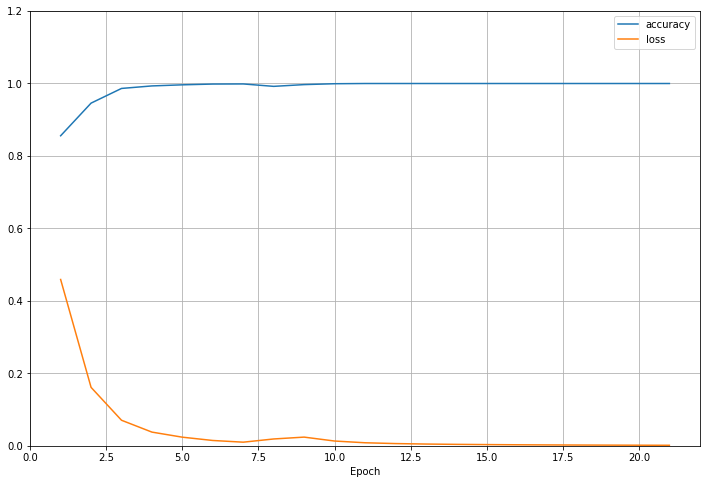

In [20]:
y_acc=hist2.history['accuracy']
y_loss=hist2.history['loss']
xs=np.arange(1,len(y_acc)+1)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs,y_acc,label='accuracy')
plt.plot(xs,y_loss,label='loss')
plt.legend(),plt.grid()
plt.ylim(0,1.2),plt.xlabel('Epoch')
plt.show()

## 1-2.GRU 스팸 분류
[0.06957137584686279, 0.9874274730682373]

In [21]:
model3=Sequential([
                  Embedding(vocab_size,32,input_length=max_len),
                  GRU(32),
                  Dense(1,activation='sigmoid')
])

model3.compile('adam','binary_crossentropy',['accuracy'])
model3_path='best-spam-lstm.h5'
mc=ModelCheckpoint(model3_path,verbose=1,save_best_only=True)
es=EarlyStopping(patience=10)

hist3=model3.fit(
    X_train,y_train,validation_split=0.2,
    epochs=100,batch_size=64,callbacks=[mc,es]
)
best_model=load_model(model3_path)
best_model.evaluate(X_test,y_test)

Epoch 1/100
49/52 [===========================>..] - ETA: 0s - loss: 0.4857 - accuracy: 0.8543
Epoch 1: val_loss improved from inf to 0.23615, saving model to best-spam-lstm.h5
52/52 [==============================] - 3s 21ms/step - loss: 0.4702 - accuracy: 0.8582 - val_loss: 0.2361 - val_accuracy: 0.8948
Epoch 2/100
47/52 [==========================>...] - ETA: 0s - loss: 0.1566 - accuracy: 0.9245
Epoch 2: val_loss improved from 0.23615 to 0.09180, saving model to best-spam-lstm.h5
52/52 [==============================] - 1s 12ms/step - loss: 0.1534 - accuracy: 0.9284 - val_loss: 0.0918 - val_accuracy: 0.9722
Epoch 3/100
47/52 [==========================>...] - ETA: 0s - loss: 0.0506 - accuracy: 0.9870
Epoch 3: val_loss improved from 0.09180 to 0.07044, saving model to best-spam-lstm.h5
52/52 [==============================] - 1s 12ms/step - loss: 0.0478 - accuracy: 0.9879 - val_loss: 0.0704 - val_accuracy: 0.9782
Epoch 4/100
51/52 [============================>.] - ETA: 0s - loss: 0.

[0.06957137584686279, 0.9874274730682373]

학습과정 시각화

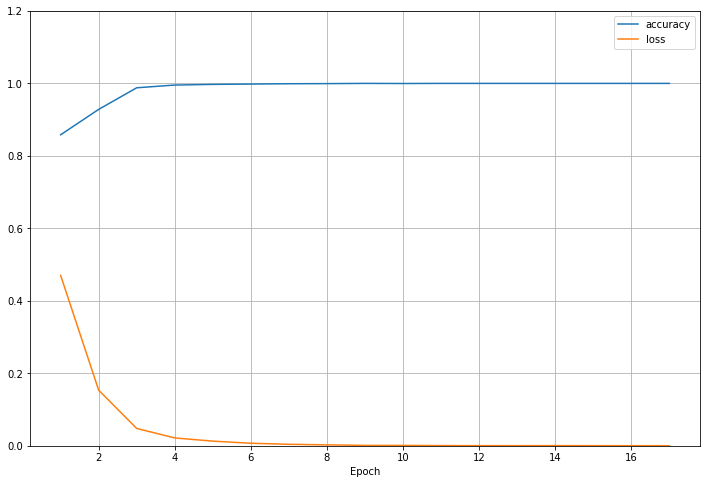

In [22]:
y_acc=hist3.history['accuracy']
y_loss=hist3.history['loss']
xs=np.arange(1,len(y_acc)+1)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(xs,y_acc,label='accuracy')
plt.plot(xs,y_loss,label='loss')
plt.legend(),plt.grid()
plt.ylim(0,1.2),plt.xlabel('Epoch')
plt.show()

# 2.스팸 분류-TfidVectorizer+LR pipeline
0.9748549323017408

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [20]:
import nltk 
nltk.download('stopwords')

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
from nltk.tokenize import word_tokenize 

stop_words = set(stopwords.words('english')) 

In [23]:
!pip install Konlpy > /dev/null 

In [24]:
from konlpy.tag import Okt
okt=Okt()
def okt_tokenizer(text):
    morphs = okt.morphs(text, stem=True)
    tokens = [word for word in morphs if word not in stop_words]
    return tokens

In [25]:
pipeline=Pipeline([
                   ('TFIDF',TfidfVectorizer(tokenizer=okt_tokenizer)),
                   ('LR', LogisticRegression(random_state=2022))
                   ])
%time pipeline.fit(x, y)

CPU times: user 6.7 s, sys: 170 ms, total: 6.87 s
Wall time: 5.55 s


Pipeline(steps=[('TFIDF',
                 TfidfVectorizer(tokenizer=<function okt_tokenizer at 0x7f21ba30d710>)),
                ('LR', LogisticRegression(random_state=2022))])

In [26]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(
    x,y,stratify=y,test_size=0.2,random_state=2022
)
X_train.shape,X_test.shape,y_train.shape, y_test.shape

((4135,), (1034,), (4135,), (1034,))

In [27]:
pipeline.score(X_test, y_test)

0.9748549323017408